In [1]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import networkx as nx


In [2]:

def read_graph_from_gml(file):
    G = nx.read_gml(file)
    pos = {}
    for node, nodedata in G.nodes.items():
        if "position" in nodedata:
            pos[node] = ast.literal_eval(nodedata["position"])
        elif "Longitude" in nodedata and "Latitude" in nodedata:
            pos[node] = [nodedata['Longitude'], nodedata['Latitude']]
        else:
            raise ValueError("Cannot determine node position.")
    nx.set_node_attributes(G, pos, name='pos')
    return G

def compute_dist_lat_lon(edge,graph):
    """Compute the distance in km between two points based on their latitude and longitude.
    Assumes both are given in radians."""
    R = 6371  # Radius of the earth in km
    node1, node2 = edge
    lon1 = np.radians(graph.nodes[node1]['Longitude'])
    lon2 = np.radians(graph.nodes[node2]['Longitude'])
    lat1 = np.radians(graph.nodes[node1]['Latitude'])
    lat2 = np.radians(graph.nodes[node2]['Latitude'])
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return np.round(R * c, 5)

In [6]:
import geopandas
states = geopandas.read_file('data/usa-states-census-2014.shp')
type(states)

ERROR 1: PROJ: proj_create_from_database: Open of /home/ubuntu/anaconda3/share/proj failed


geopandas.geodataframe.GeoDataFrame

In [25]:

f_dir = "gml_files/"
G = read_graph_from_gml(f_dir+"ESnet2.gml")
pos_list = nx.get_node_attributes(G, 'pos')
# nx.draw_networkx(G=G,  width=1, node_size = 20, with_labels=False, font_size=6, pos=pos_list)
# states.boundary.plot()
max_dist = 100


pos_list["PPPL"][0] -= 0.3
pos_list["ORAU"][0] += 0.3
pos_list["LOSA"][0] += 0.3

# orig_edges = np.copy(G.edges())
# c_edge = 0
# c_rep = 0
# weights = dict()
# for edge in orig_edges:
#     dist = compute_dist_lat_lon(edge,G)
#     if dist >= 2*max_dist:
#         n1, n2 = edge
#         G.remove_edge(n1,n2)
#         c_edge += 1
#         n_rep = int(dist/max_dist)-1
#         G.add_nodes_from(np.arange(c_rep,c_rep+n_rep))
#         G.add_edge(n1,c_rep)
#         weights[(n1,c_rep)] = dist/(n_rep+1)
#         i_r = 0
#         pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
#         G.add_edge(c_rep+n_rep-1,n2)
#         weights[(c_rep+n_rep-1,n2)] = dist/(n_rep+1)
#         i_r = n_rep -1
#         pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
#         for i_r in range(0,n_rep-1):
#             G.add_edge(i_r+c_rep,i_r+c_rep+1)
#             pos_list[(i_r+c_rep)] = list(np.array(pos_list[n1])+ (np.array(pos_list[n2])-np.array(pos_list[n1]))/(n_rep+1)*(i_r+1))
#             weights[(i_r+c_rep,i_r+c_rep+1)] = dist/(n_rep+1)
            
#         c_rep += n_rep
#     else:
#         n1, n2 = edge
#         weights[(n1,n2)] = dist
        
# nx.set_edge_attributes(G, values = weights, name = 'weight')

print("No. of modified edges longer than %.0f km: " % max_dist,c_edge)
print("No. of aux. nodes=",c_rep)

end_node_list = ["PNNL","LIGO","HLAN","NETLALB","INL","SNLL",\
                "LBNL","NERSC","SLAC","LLNL","GA","NNSS","LANL-NNSS",\
                "NREL","LANL","SNLA","KCNSC-NM","NGA-SW","KCNSC",\
                "PANTEX","ORNL","DOE-SC-OSTI","FNAL","AMES","ANL",\
                "ORCC","Y12","SRS","ORAU","LNS","PSFC","NREL-DC",\
                "BNL","JLAB","PPPL","NETLPGH","NETLMGN","FRIB"]

color_map = []
for node, nodedata in G.nodes.items():
    if type(node)==np.int64:
        nodedata['type'] = 'auxiliary'
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
        else:
            nodedata['type'] = 'router'

No. of modified edges longer than 100 km:  44
No. of aux. nodes= 180


In [5]:
# print(G.nodes())
# nx.draw_networkx(G,pos=pos_list,with_labels=True,node_size=4,font_size=8)
print(nx.has_path(G, source="SALT", target="DENV"))
print(nx.shortest_path_length(G, source="SALT", target="DENV"))
print(nx.shortest_path_length(G, source="SALT", target="DENV", weight="weight"))


True
6
602.3628


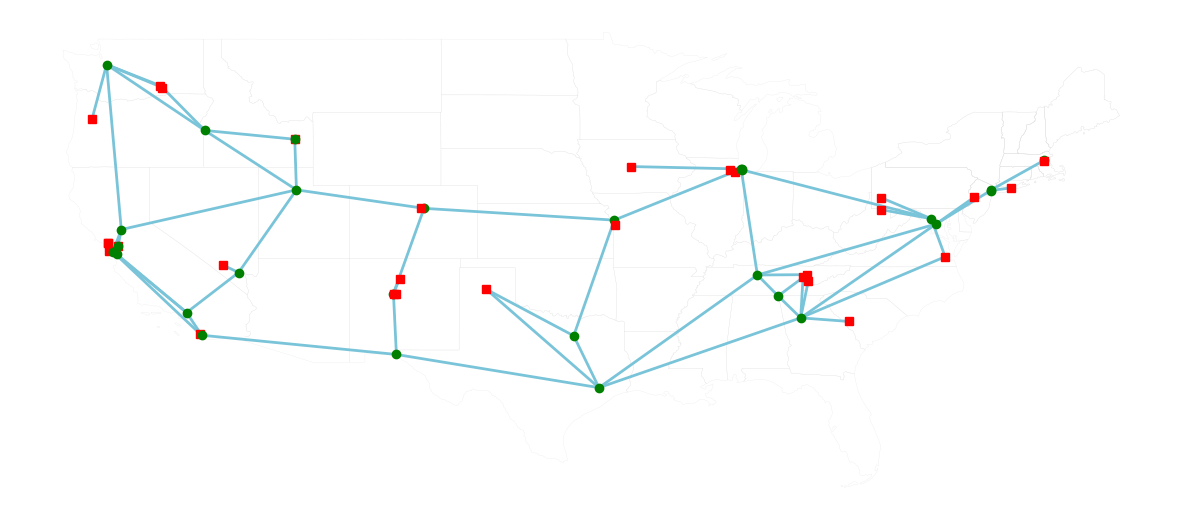

In [35]:
fig,ax = plt.subplots(figsize = (15,15))
states.boundary.plot(ax = ax,linewidth=0.1,color="lightgray")

# fig,ax = plt.subplots(figsize = (20,10))

for link in G.edges():
    node1, node2 = link
    plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],color="#7AC4D9",linewidth=2)

for node, nodedata in G.nodes.items():
    if nodedata['type'] == 'auxiliary':
        plt.plot(pos_list[node][0],pos_list[node][1],"o",markerfacecolor="white",color='black',markersize=4)
    else:
        if node in end_node_list:
            nodedata['type'] = 'site'
            plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
#             plt.text(pos_list[node][0],pos_list[node][1],node)
        else:
            nodedata['type'] = 'router'
            plt.plot(pos_list[node][0],pos_list[node][1],"o",color='green')
#             plt.text(pos_list[node][0],pos_list[node][1],node)


# e = ("ALBQ","AMES")
# e = ("SLAC","GA")
# path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
# for i in range(len(path)-1):
#     e1 = path[i]
#     e2 = path[i+1]
#     plt.plot([ pos_list[e1][0],pos_list[e2][0] ], [ pos_list[e1][1],pos_list[e2][1] ], color = "green", linewidth=1)
# print(nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight"))

# ax.set_xlim([-90,-70])
# ax.set_ylim([35,40])
# plt.grid()
# print(path)
plt.axis("off")
plt.savefig("us-map-w-nodes.pdf")
plt.show()


# draw solution

In [73]:
user_pairs = [('ORNL', 'ANL'),('SLAC', 'GA'),('NERSC', 'INL'),('FNAL', 'Y12'),('PSFC', 'JLAB'),('KCNSC', 'AMES')]
W_list = [50,100,100,50,100,100]
paths = [ \
         [('ORNL', 225), (225, 109), (109, 'ANL')], \
         [('SLAC', 283), (283, 192), (192, 'GA')], \
         [('NERSC', 'EQXSV5'), ('EQXSV5', 269), (269, 286), (286, 'INL')], \
         [('FNAL', 'ANL'), ('ANL', 109), (109, 224), (224, 28), (28, 'Y12')],\
         [('PSFC', 'NEWY32AOA'), ('NEWY32AOA', 'BNL'), ('BNL', 259), (259, 'WASH'), ('WASH', 'JLAB')],\
         [('KCNSC', 'KANS'), ('KANS', 'CHIC'), ('CHIC', 'AMES')]
]
# [('ORNL', 225), (225, 109), (109, 'ANL')] 
# W[] 50.0 min p 1.2499827755254666e-12 E_p 1.5624784694068333e-11  R 50  
# D is  100 100
# user pair ('SLAC', 'GA') uses edges [('SLAC', 283), (283, 192), (192, 'GA')] W 100.0 min p 5.0014902736230485e-12 E_p 1.2503725684057622e-10  R 50   
# D is  100 100
# user pair ('NERSC', 'INL') uses edges [('NERSC', 'EQXSV5'), ('EQXSV5', 269), (269, 286), (286, 'INL')] W 100.0 min p 1.6929409105303876e-17 E_p 2.1161761381629845e-16  R 50  
# D is  100 100
# user pair ('FNAL', 'Y12') uses edges [('FNAL', 'ANL'), ('ANL', 109), (109, 224), (224, 28), (28, 'Y12')] W 50.0 min p 1.2499827755254666e-12 E_p 3.906196173517083e-12  R 50    
# D is  100 100
# user pair ('PSFC', 'JLAB') uses edges [('PSFC', 'NEWY32AOA'), ('NEWY32AOA', 'BNL'), ('BNL', 259), (259, 'WASH'), ('WASH', 'JLAB')] W 100.0 min p 1.4676050584981667e-07 E_p 9.172531615613542e-07  R 50   
# D is  100 100
# user pair ('KCNSC', 'AMES') uses edges [('KCNSC', 'KANS'), ('KANS', 'CHIC'), ('CHIC', 'AMES')] W 100.0 min p 1.475070576005755e-15 E_p 3.6876764400143874e-14  R 50  

('SLAC', 'GA')
('NERSC', 'INL')


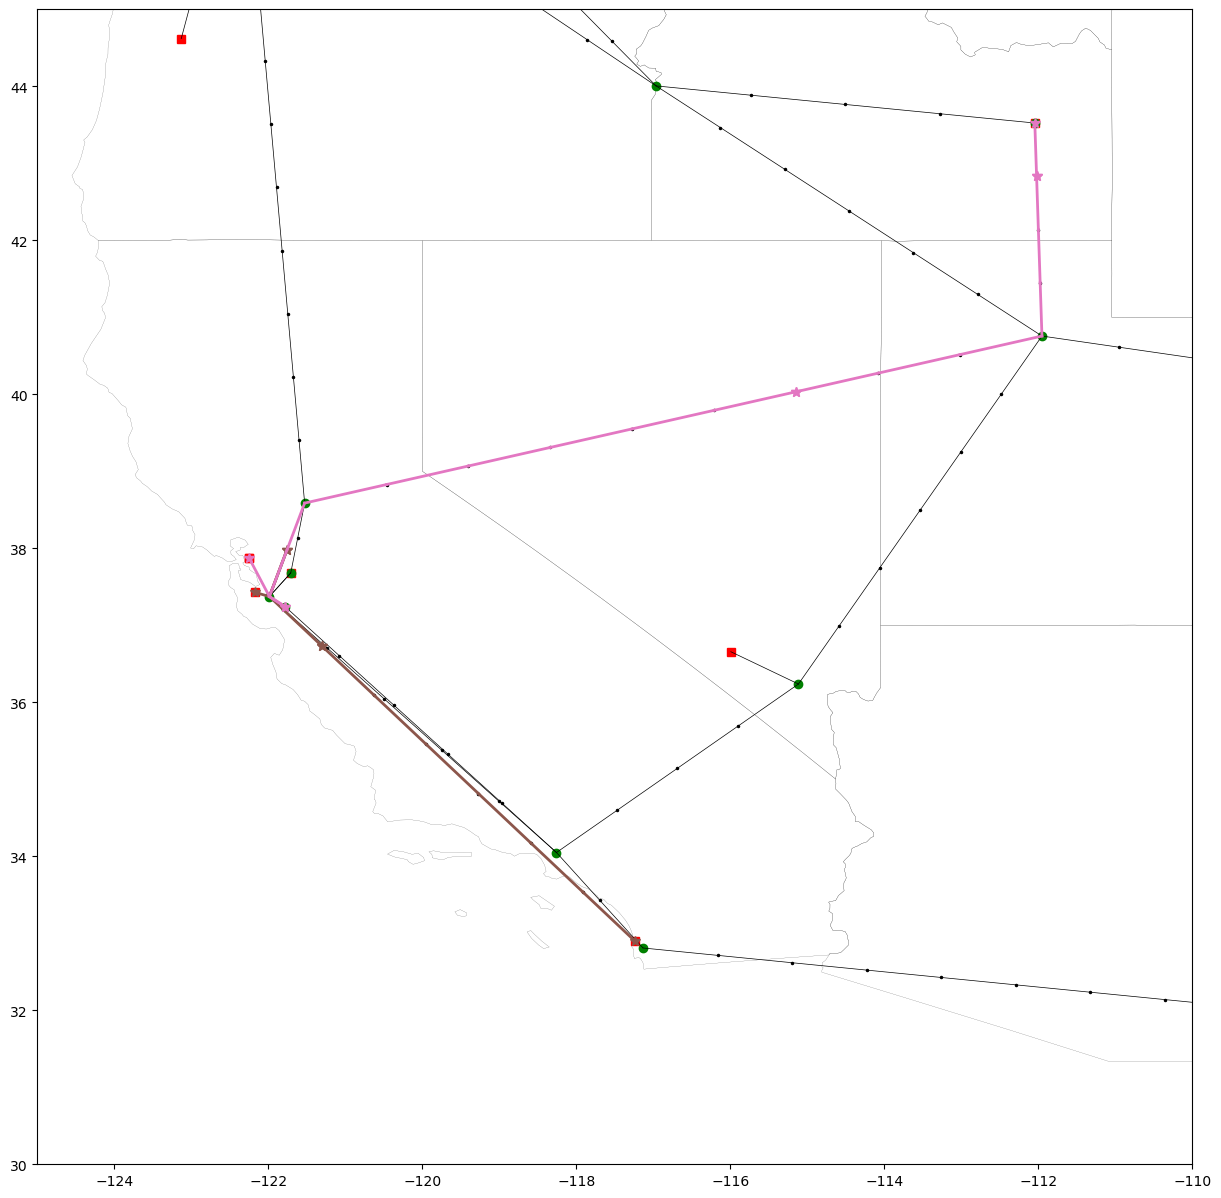

[83.86307, 733.2398700000001, 515.38239, 77.35519000000001]


In [81]:
fig,ax = plt.subplots(figsize = (15,15))
states.boundary.plot(ax = ax,linewidth=0.1,color="black")

# fig,ax = plt.subplots(figsize = (20,10))

for node, nodedata in G.nodes.items():
    if nodedata['type'] == 'auxiliary':
        plt.plot(pos_list[node][0],pos_list[node][1],".",color='black',markersize=3)
    else:
#     if nodedata['type'] != 'auxiliary':
        if node in end_node_list:
            nodedata['type'] = 'site'
            plt.plot(pos_list[node][0],pos_list[node][1],"s",color='red')
#             plt.text(pos_list[node][0],pos_list[node][1],node)
        else:
            nodedata['type'] = 'router'
            plt.plot(pos_list[node][0],pos_list[node][1],"o",color='green')

for link in G.edges():
    node1, node2 = link
    plt.plot([pos_list[node1][0],pos_list[node2][0]],[pos_list[node1][1],pos_list[node2][1]],'k',linewidth=0.5)

shift_color = 4
# for i_u, user_pair in enumerate(user_pairs):
for i_u in [1,2]:
# i_u = 2
    user_pair = user_pairs[i_u]
    print(user_pair)
    e2e_path = paths[i_u]
    dist_list = []
    for i in range(len(e2e_path)):
        e = e2e_path[i]
    #         print(e)
    #         plt.plot([ pos_list[e1][0],pos_list[e2][0] ], [ pos_list[e1][1],pos_list[e2][1] ], color = "C%d" % i_u, linewidth=1)
        if G.has_edge(e[0],e[1]):
    #             if plot_on:
            plt.plot([ pos_list[e[0]][0],pos_list[e[1]][0] ], [ pos_list[e[0]][1],pos_list[e[1]][1] ], color = "C%d" % (i_u+shift_color), linewidth=2)
            dist_list.append(nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight"))
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            dist_list.append(nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight"))
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
    #                 if plot_on:
                plt.plot([ pos_list[e1][0],pos_list[e2][0] ], [ pos_list[e1][1],pos_list[e2][1] ], color = "C%d" % (i_u+shift_color), linewidth=2)

        plt.plot(pos_list[e[0]][0], pos_list[e[0]][1], "*",markersize=7, color = "C%d" % (i_u+shift_color))
        plt.plot(pos_list[e[1]][0], pos_list[e[1]][1], "*",markersize=7, color = "C%d" % (i_u+shift_color))

# plt.xlim([-125,-115]) # i_u = 1
# plt.xlim([-125,-110]) # i_u = 2
# plt.ylim([30,45])
# plt.ylim([35,43])
# plt.xlim([-80,-70])
plt.show()
print(dist_list)

In [41]:
# path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
# print(path)


[286, 'INLEIL', 'INL']


In [ ]:
# Importing required library
from mpl_interactions import ioff, panhandler, zoom_factory
import matplotlib.pyplot as plt
%matplotlib widget

# creating the dataset
data = {'Operating System': 10, 'Data Structure': 7,
		'Machine Learning': 14, 'Deep Learning': 12}
courses = list(data.keys())
values = list(data.values())
# Enable scroll to zoom with the help of MPL
# Interactions library function like ioff and zoom_factory.
with plt.ioff():
	figure, axis = plt.subplots()
# creating the bar plot
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.bar(courses, values, color='green', width=0.4)
disconnect_zoom = zoom_factory(axis)
# Enable scrolling and panning with the help of MPL
# Interactions library function like panhandler.
pan_handler = panhandler(figure)
display(figure.canvas)
